### Based on the paper from Goodwill et al.

In [31]:
import math
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from tools.nbloader import NotebookLoader
from scipy import stats
from tools.traceloader import ASCAD, TraceGroup, TraceCategory

trace_len = 50
sample_size = 350

def gen_trace(key=0, mu=128):
    return np.array([np.random.normal(mu + (key/256 - 1), 1, trace_len) for _ in range(sample_size)], dtype=np.uint8)

def gen_mask_trace(mu=128):
    random_keys = np.random.uniform(0, 256, sample_size) / 256

    return np.array([np.random.normal(mu + (rk - 1), 1, trace_len) for rk in random_keys], dtype=np.uint8)

tg_a1 = gen_trace(0)
tg_a2 = gen_trace(256)
tg_b = gen_mask_trace()

gen_mask_trace()

array([[128, 125, 127, ..., 127, 127, 126],
       [126, 126, 126, ..., 127, 127, 127],
       [128, 126, 128, ..., 127, 126, 128],
       ...,
       [124, 127, 126, ..., 126, 128, 129],
       [125, 127, 129, ..., 128, 126, 127],
       [127, 127, 127, ..., 125, 126, 128]], dtype=uint8)

In [32]:
def confidence_level(all_t_values, p=.95):
    tvs_flat = abs(all_t_values.flatten())
    n = round(len(tvs_flat) * p)

    return sorted(tvs_flat)[n]

def device_fails(ta: np.array, tb: np.array, c=2.5):
    """
    @param ta should be a positive-valued array of t-test results from some power trace with given key.
    @param tb should be a positive-valued array of t-test results from a different set of traces with the same key.
    @param c should be the confidence value.
    """
    return np.array((ta >= c) * (tb >= c)).any()

def t_test(a, b):
    num = a.mean(axis=0) - b.mean(axis=0)
    den = (((a.var(axis=0) / len(a)) + (b.var(axis=0) / len(b))) ** .5)

    return np.array(num / den)

def stats_t_test(a, b):
    return stats.ttest_ind(a, b, equal_var=False)[0]

def gen_rvs(mean=5):
    return lambda: np.array([stats.norm.rvs(loc=mean,scale=.1,size=50) for _ in range(50)])

def tvla(test, lefts, rights):
    a, b, c, d = lefts
    x, y = rights

    tk1 = abs(np.array(test(a, c)))
    tk2 = abs(np.array(test(b, d)))
    tm1 = abs(np.array(test(a, x)))
    tm2 = abs(np.array(test(b, y)))

    confidence = np.percentile(np.array([*tk1, *tk2, *tm1, *tm2]).flatten(), 95)

    return device_fails(tk1, tk2, confidence), device_fails(tm1, tm2, confidence)

def bench(test, gen_one, gen_two, total=100):
    acc = np.array([(False, False)] * total)
    for ix in tqdm(range(total)):
        acc[ix] = tvla(test, [gen_one() for _ in range(4)], (gen_two(), gen_two()))

    return np.array(acc).sum(axis=0)

In [33]:
# bench(t_test, gen_rvs(5), gen_rvs(6))

In [34]:
# bench(t_test, gen_trace, gen_mask_trace)

In [35]:
ascad = ASCAD()

In [89]:
def split_traces(tc: TraceCategory):
    res = {}

    for k in range(256):
        ts = tc.filter_traces(k)

        np.random.shuffle(ts)
        ts4 = np.array(np.array_split(ts.copy(), 4))
        np.random.shuffle(ts)
        ts2 = np.array(np.array_split(ts, 2))

        res[k] = (ts4, ts2)

    return res

def gen_tables(trace_categories, target_size):
    for cat in trace_categories:
        for

class CTableStore:
    def __init__(self, tc: TraceCategory):
        self.tc = tc
        self.largest = max([math.ceil(len(self.tc.filter_traces(k)) / 2) for k in range(256)])
        self.split = split_traces(tc)

        self.data = gen_tables(self.split, self.largest)



def create_ctable(tc: TraceCategory):
    k0 = tc.filter_traces(0)
    k255 = tc.filter_traces(255)

    ct0 = gen_tables(k0, 4)
    ct255 = gen_tables(k255, 2)

cts = CTableStore(ascad.default.profile)
cts.largest

SyntaxError: invalid syntax (<ipython-input-89-83cad881bd28>, line 18)

In [174]:
def smote(trace_categories, target_size):
    def get_point(traces):
        t_shape = traces.shape
        x, y = 0, 0
        while x == y:
            x, y = np.random.randint(t_shape[0]), np.random.randint(t_shape[0])

        return np.array((traces[x] + traces[y]) * np.random.uniform(high=.5, size=t_shape[1]))

    acc = []
    for c_ix, category in enumerate(trace_categories):
        res = np.zeros((category.shape[0], target_size, category.shape[2]))

        for s_ix, trace_slice in enumerate(category):
            app = np.round([get_point(trace_slice) for _ in range(target_size - len(trace_slice))])
            res[s_ix] = np.concatenate((trace_slice, app))

        acc.append(res)

    return acc

smote(np.array([np.array(np.array_split(ascad.default.profile.filter_traces(0), 4)),
                np.array(np.array_split(ascad.default.profile.filter_traces(0), 2))]), 400)

(4, 400, 1400)
(2, 400, 1400)


[array([[[  17.,  -75.,  -53., ...,  -79.,  -89.,  -24.],
         [ -89.,    3.,  -69., ...,   27.,  -77.,  -60.],
         [ -87.,  -98.,  -93., ...,  -76.,  -27.,  -84.],
         ...,
         [  23.,    0.,   -2., ...,   -1.,   36.,   20.],
         [  30.,  -40.,   41., ...,   54.,  -15.,   17.],
         [  -8.,   -6.,   25., ...,  -14.,   16.,   25.]],
 
        [[ -92.,  -82.,  -69., ...,  -86.,  -60.,  -33.],
         [ -80.,  -82.,  -40., ...,  -82.,  -88.,  -88.],
         [ -86.,  -61.,  -96., ...,   47.,   -5.,  -29.],
         ...,
         [   4.,    0.,    9., ...,   19.,   -1.,   33.],
         [  26.,   14.,   23., ...,   -9.,   -3.,  -23.],
         [  32.,    5.,  -18., ...,  -20.,  -24.,   18.]],
 
        [[ -51.,  -87.,  -14., ...,  -88.,  -88.,  -23.],
         [ -45.,  -87.,  -85., ...,  -56.,  -26.,  -88.],
         [   4.,  -18.,  -80., ...,  -31.,   46.,  -52.],
         ...,
         [  32.,   27.,   33., ...,  -37.,   -2.,   39.],
         [ -26.,    1., 

In [ ]:
def plus_one(x):
    x[0] += 1

    return x

np.apply_along_axis(plus_one, 2, np.array([[np.zeros(3)] * 3] * 3))

In [37]:
trc = np.array([round(np.random.uniform(0, 255)) for _ in range(100000)])

def ctable_mv(ctable: np.array, num_observations: int):
    """
    Calculates the mean and variance from a contingency table with a corresponding number of observations.
    """
    # Using 128-bit floats prevents some rounding errors when comparing with the np implementation of var and mean.
    ixs = np.arange(0, len(ctable), dtype=np.float128)

    mu = (ctable * ixs).sum() / num_observations
    sigma2 = ((ctable * ixs ** 2).sum() / num_observations) - (mu ** 2)

    return mu, sigma2

print(ctable_mv(np.bincount(trc, minlength=256), len(trc)))

# Actual mean and variance
trc.mean(), trc.var()

(127.57559, 5402.1428061519000012)


(127.57559, 5402.1428061519)

In [38]:
# Bench for CTable




In [39]:
def plot_longform(traces):
    sns.set_style('whitegrid')

    longform = []
    for trace in traces:
        for ix in range(len(trace)):
            longform.append((ix, trace[ix]))

    cols = ["Sample point", "Power"]
    df = pd.DataFrame(longform, columns=cols)
    sns.lineplot(data=df, x=cols[0], y=cols[1])

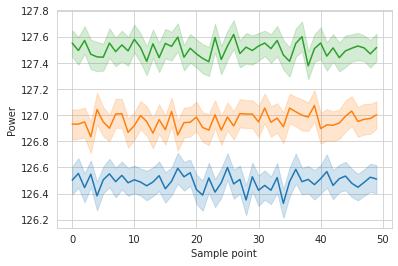

In [40]:
plot_longform(gen_trace(0))
plot_longform(gen_mask_trace())
plot_longform(gen_trace(256))